**Rozdział 9. Instalacja i korzystanie z modułu TensorFlow**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 9._

# Konfiguracja

Upewnijmy się najpierw, że notatnik ten będzie działał w środowiskach Python 2 i 3, importujmy kilka powszechnie stosowanych modułów, upewnijmy się, że moduł MatplotLib będzie prawidłowo tworzył wykresy, a także przygotujmy funkcję zapisującą rysunki:

In [1]:
# Obsługa środowisk Python 2 i Python 3
from __future__ import division, print_function, unicode_literals

# Importowanie popularnych modułów
import numpy as np
import os

# W celu zachowania powtarzalności wyników w kolejnych przebiegach
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Generowanie ładnych wykresów
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Lokacja, w której będą zapisywane rysunki
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID, fig_id + ".png")
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Tworzenie i uruchomienie grafu

In [2]:
import tensorflow as tf

reset_graph()

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [4]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [5]:
sess.close()

In [6]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

In [7]:
result

42

In [11]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    result = f.eval()

In [12]:
result

42

In [10]:
init = tf.global_variables_initializer()

In [13]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)

42


In [14]:
sess.close()

In [15]:
result

42

# Zarządzanie grafami

In [16]:
reset_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [17]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [18]:
x2.graph is tf.get_default_graph()

False

In [19]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [20]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# Regresja liniowa

## Korzystanie z równania normalnego

In [21]:
import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [22]:
theta_value

array([[-3.6959320e+01],
       [ 4.3698898e-01],
       [ 9.4245886e-03],
       [-1.0791138e-01],
       [ 6.4842808e-01],
       [-3.9986235e-06],
       [-3.7866351e-03],
       [-4.2142656e-01],
       [-4.3467718e-01]], dtype=float32)

Porównajmy z implementacją NumPy:

In [23]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


Porównajmy z implementacją Scikit-Learn:

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


## Korzystanie ze wsadowego gradientu prostego

Gradient prosty wymaga uprzedniego wyskalowania wektorów cech. Moglibyśmy dokonać tego za pomocą modułu TensorFlow, skorzystajmy jednak na razie z biblioteki Scikit-Learn.

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [26]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


### Ręczne obliczanie gradientów

In [27]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="teta")
y_pred = tf.matmul(X, theta, name="prognozy")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoka", epoch, "Błąd MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoka 0 Błąd MSE = 9.161542
Epoka 100 Błąd MSE = 0.71450055
Epoka 200 Błąd MSE = 0.56670487
Epoka 300 Błąd MSE = 0.55557173
Epoka 400 Błąd MSE = 0.5488112
Epoka 500 Błąd MSE = 0.5436363
Epoka 600 Błąd MSE = 0.53962904
Epoka 700 Błąd MSE = 0.5365092
Epoka 800 Błąd MSE = 0.53406775
Epoka 900 Błąd MSE = 0.5321473


In [28]:
best_theta

array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.34770885],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145283],
       [-0.6375278 ]], dtype=float32)

### Korzystanie z różniczkowania automatycznego

To samo, co powyżej oprócz wiersza `gradients = ...`:

In [29]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="teta")
y_pred = tf.matmul(X, theta, name="prognozy")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [30]:
gradients = tf.gradients(mse, [theta])[0]

In [31]:
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoka", epoch, "Błąd MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Najlepszy parametr teta:")
print(best_theta)

Epoka 0 Błąd MSE = 9.161542
Epoka 100 Błąd MSE = 0.7145004
Epoka 200 Błąd MSE = 0.56670487
Epoka 300 Błąd MSE = 0.55557173
Epoka 400 Błąd MSE = 0.5488112
Epoka 500 Błąd MSE = 0.5436363
Epoka 600 Błąd MSE = 0.53962904
Epoka 700 Błąd MSE = 0.5365092
Epoka 800 Błąd MSE = 0.53406775
Epoka 900 Błąd MSE = 0.5321473
Najlepszy parametr teta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


Jak możemy znaleźć pochodne cząstkowe poniższej funkcji w odniesieniu do wartości `a` i `b`?

In [32]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

In [33]:
my_func(0.2, 0.3)

-0.21253923284754914

In [34]:
reset_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)

grads = tf.gradients(z, [a, b])
init = tf.global_variables_initializer()

Obliczmy tę funkcję w punktach $a=0,2$ i $b=0,3$ oraz jej pochodne cząstkowe w odniesieniu do punktów $a$ i $b$:

In [35]:
with tf.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.21253741
[-1.1388494, 0.19671395]


### Korzystanie z klasy `GradientDescentOptimizer`

In [37]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="teta")
y_pred = tf.matmul(X, theta, name="prognozy")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [38]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

In [39]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoka", epoch, "Błąd MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Najlepszy parametr teta:")
print(best_theta)

Epoka 0 Błąd MSE = 9.161542
Epoka 100 Błąd MSE = 0.7145004
Epoka 200 Błąd MSE = 0.56670487
Epoka 300 Błąd MSE = 0.55557173
Epoka 400 Błąd MSE = 0.5488112
Epoka 500 Błąd MSE = 0.5436363
Epoka 600 Błąd MSE = 0.53962904
Epoka 700 Błąd MSE = 0.5365092
Epoka 800 Błąd MSE = 0.53406775
Epoka 900 Błąd MSE = 0.5321473
Najlepszy parametr teta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


### Korzystanie z optymalizatora momentowego

In [40]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="teta")
y_pred = tf.matmul(X, theta, name="prognozy")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [41]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

In [42]:
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [43]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Najlepszy parametr teta:")
print(best_theta)

Najlepszy parametr teta:
[[ 2.068558  ]
 [ 0.8296286 ]
 [ 0.11875337]
 [-0.26554456]
 [ 0.3057109 ]
 [-0.00450251]
 [-0.03932662]
 [-0.89986444]
 [-0.87052065]]


# Dostarczanie danych do algorytmu uczącego

## Węzły zastępcze

In [44]:
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)

[[6. 7. 8.]]


In [45]:
print(B_val_2)

[[ 9. 10. 11.]
 [12. 13. 14.]]


## Schodzenie po gradiencie z mini-grupami

In [46]:
n_epochs = 1000
learning_rate = 0.01

In [47]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [48]:
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="teta")
y_pred = tf.matmul(X, theta, name="prognozy")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [49]:
n_epochs = 10

In [50]:
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [51]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # nieukazane w książce
    indices = np.random.randint(m, size=batch_size)  # nieukazane
    X_batch = scaled_housing_data_plus_bias[indices] # nieukazane
    y_batch = housing.target.reshape(-1, 1)[indices] # nieukazane
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

In [52]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

# Zapisywanie i wczytywanie modelu

In [80]:
reset_graph()

n_epochs = 1000                                                                       # nieukazane w książce
learning_rate = 0.01                                                                  # nieukazane

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # nieukazane
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            # nieukazane
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="teta")
y_pred = tf.matmul(X, theta, name="prognozy")                                      # nieukazane
error = y_pred - y                                                                    # nieukazane
mse = tf.reduce_mean(tf.square(error), name="mse")                                    # nieukazane
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            # nieukazane
training_op = optimizer.minimize(mse)                                                 # nieukazane

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoka", epoch, "Błąd MSE =", mse.eval())                                # nieukazane
            save_path = saver.save(sess, "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/moj_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/moj_model_ostateczny.ckpt")

Epoka 0 Błąd MSE = 9.161542
Epoka 100 Błąd MSE = 0.7145004
Epoka 200 Błąd MSE = 0.56670487
Epoka 300 Błąd MSE = 0.55557173
Epoka 400 Błąd MSE = 0.5488112
Epoka 500 Błąd MSE = 0.5436363
Epoka 600 Błąd MSE = 0.53962904
Epoka 700 Błąd MSE = 0.5365092
Epoka 800 Błąd MSE = 0.53406775
Epoka 900 Błąd MSE = 0.5321473


In [81]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

In [82]:
with tf.Session() as sess:
    saver.restore(sess, "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/moj_model_ostateczny.ckpt")
    best_theta_restored = theta.eval() # nieukazane w książce

INFO:tensorflow:Restoring parameters from /Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/moj_model_ostateczny.ckpt


In [83]:
np.allclose(best_theta, best_theta_restored)

True

Jeśli chcesz mieć obiekt `Saver` wczytujący i odtwarzający wartość `theta` pod inną nazwą, np. `"wagi"`:

In [84]:
saver = tf.train.Saver({"wagi": theta})

Domyślnie obiekt ten zachowuje również strukturę samego grafu w drugim pliku o rozszerzeniu `.meta`. Możesz użyć funkcji `tf.train.import_meta_graph()` do wczytania struktury grafu. Funkcja ta wczytuje tę strukturę do domyślnego grafu i zwraca węzeł `Saver`, za pomocą którego jesteśmy w stanie odtworzyć stan grafu (np. wartości zmiennych):

In [85]:
reset_graph()
# zwróć uwagę, że zaczynamy od pustego grafu

saver = tf.train.import_meta_graph("/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/moj_model_ostateczny.ckpt.meta")  # wczytuje strukturę grafu 
theta = tf.get_default_graph().get_tensor_by_name("teta:0") # nieukazane w książce

with tf.Session() as sess:
    saver.restore(sess, "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/moj_model_ostateczny.ckpt")  # wczytuje stan grafu
    best_theta_restored = theta.eval() # nieukazane w książce

INFO:tensorflow:Restoring parameters from /Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/moj_model_ostateczny.ckpt


In [86]:
np.allclose(best_theta, best_theta_restored)

True

Oznacza to, że możemy importować wstępnie wyuczony model bez konieczności posiadania kodu Python służącego do stworzenia tego grafu. Jest to bardzo przydatne podczas regulowania i zapisywania modelu: możesz wczytać uprzednio zapisany model bez potrzeby wyszukiwania wersji kodu odpowiedzialnego za architekturę grafu.

# Wizualizowanie grafu
## Wewnątrz notatnika  Jupyter

In [107]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Wyciąga duże wartości stałych z obiektu graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Wizualizuje graf TensorFlow."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graf'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [108]:
show_graph(tf.get_default_graph())

## Korzystanie z aplikacji TensorBoard

In [100]:
reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/tf_dzienniki"
logdir = "{}/przebieg-{}/".format(root_logdir, now)

In [101]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="teta")
y_pred = tf.matmul(X, theta, name="prognozy")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [102]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [103]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [104]:
with tf.Session() as sess:                                                        # nieukazane w książce
    sess.run(init)                                                                # nieukazane

    for epoch in range(n_epochs):                                                 # nieukazane
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()                                                     # nieukazane

In [105]:
file_writer.close()

In [106]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

# Zakresy nazw

In [115]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/tf_dzienniki"
logdir = "{}/przebieg-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="teta")
y_pred = tf.matmul(X, theta, name="prognozy")

In [116]:
with tf.name_scope("strata") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [117]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [118]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Najlepszy parametr teta:")
print(best_theta)

Najlepszy parametr teta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


In [119]:
print(error.op.name)

strata/sub


In [120]:
print(mse.op.name)

strata/mse


In [121]:
reset_graph()

a1 = tf.Variable(0, name="a")      # nazwa == "a"
a2 = tf.Variable(0, name="a")      # nazwa == "a_1"

with tf.name_scope("param"):       # nazwa == "param"
    a3 = tf.Variable(0, name="a")  # nazwa == "param/a"

with tf.name_scope("param"):       # nazwa == "param_1"
    a4 = tf.Variable(0, name="a")  # nazwa == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


# Modułowość

Brzydki, prosty kod:

In [122]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="wagi1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="wagi2")
b1 = tf.Variable(0.0, name="obciazenie1")
b2 = tf.Variable(0.0, name="obciazenie2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z1, 0., name="relu2")  # Ups, błąd kopiowania i wklejania! Zauważyłaś/zauważyłeś go? 

output = tf.add(relu1, relu2, name="wyjscie")

Znacznie lepiej jest wykorzystać funkcję do tworzenia jednostek ReLU:

In [123]:
reset_graph()

def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="wagi")
    b = tf.Variable(0.0, name="obciazenie")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="wyjscie")

In [124]:
file_writer = tf.summary.FileWriter("/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/dzienniki/relu1", tf.get_default_graph())

Jeszcze lepszym rozwiązaniem jest użycie zakresów nazw:

In [125]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          # nieukazane w książce
        w = tf.Variable(tf.random_normal(w_shape), name="wagi")    # nieukazane
        b = tf.Variable(0.0, name="obciazenie")                             # nieukazane
        z = tf.add(tf.matmul(X, w), b, name="z")                      # nieukazane
        return tf.maximum(z, 0., name="max")                          # nieukazane

In [126]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="wyjscie")

file_writer = tf.summary.FileWriter("/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/dzienniki/relu2", tf.get_default_graph())
file_writer.close()

## Udostępnianie zmiennych

Udostępnianie zmiennej `threshold` w klasyczny sposób poprzez zdefiniowanie jej poza funkcją `relu()`, a następnie przekazanie jej w postaci parametru:

In [127]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                        # nieukazane w książce
        w = tf.Variable(tf.random_normal(w_shape), name="wagi")  # nieukazane
        b = tf.Variable(0.0, name="obciazenie")                           # nieukazane
        z = tf.add(tf.matmul(X, w), b, name="z")                    # nieukazane
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="prog")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="wyjscie")

In [128]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "prog"):
            relu.threshold = tf.Variable(0.0, name="prog")
        w_shape = int(X.get_shape()[1]), 1                          # nieukazane w książce
        w = tf.Variable(tf.random_normal(w_shape), name="wagi")  # nieukazane
        b = tf.Variable(0.0, name="obciazenie")                           # nieukazane
        z = tf.add(tf.matmul(X, w), b, name="z")                    # nieukazane
        return tf.maximum(z, relu.threshold, name="max")

In [129]:
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="wyjscie")

In [130]:
reset_graph()

with tf.variable_scope("relu"):
    threshold = tf.get_variable("prog", shape=(),
                                initializer=tf.constant_initializer(0.0))

In [131]:
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("prog")

In [132]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("prog")

In [133]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("prog")
        w_shape = int(X.get_shape()[1]), 1                          # nieukazane
        w = tf.Variable(tf.random_normal(w_shape), name="wagi")  # nieukazane
        b = tf.Variable(0.0, name="obciazenie")                           # nieukazane
        z = tf.add(tf.matmul(X, w), b, name="z")                    # nieukazane
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("prog", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="wyjscie")

In [135]:
file_writer = tf.summary.FileWriter("/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/dzienniki/relu6", tf.get_default_graph())
file_writer.close()

In [136]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu"):
        threshold = tf.get_variable("prog", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="wagi")
        b = tf.Variable(0.0, name="obciazenie")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # tworzy współdzieloną zmienną
    scope.reuse_variables()  # następnie ją wykorzystuje
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="wyjscie")

file_writer = tf.summary.FileWriter("/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/dzienniki/relu8", tf.get_default_graph())
file_writer.close()

In [137]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("prog", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # nieukazane w książce
    w = tf.Variable(tf.random_normal(w_shape), name="wagi")  # nieukazane
    b = tf.Variable(0.0, name="obciazenie")                           # nieukazane
    z = tf.add(tf.matmul(X, w), b, name="z")                    # nieukazane
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="wyjscie")

In [138]:
file_writer = tf.summary.FileWriter("/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/dzienniki/relu9", tf.get_default_graph())
file_writer.close()

# Materiały dodatkowe

In [139]:
reset_graph()

with tf.variable_scope("moj_zakres"):
    x0 = tf.get_variable("x", shape=(), initializer=tf.constant_initializer(0.))
    x1 = tf.Variable(0., name="x")
    x2 = tf.Variable(0., name="x")

with tf.variable_scope("moj_zakres", reuse=True):
    x3 = tf.get_variable("x")
    x4 = tf.Variable(0., name="x")

with tf.variable_scope("", default_name="", reuse=True):
    x5 = tf.get_variable("moj_zakres/x")

print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)
print("x3:", x3.op.name)
print("x4:", x4.op.name)
print("x5:", x5.op.name)
print(x0 is x3 and x3 is x5)

x0: moj_zakres/x
x1: moj_zakres/x_1
x2: moj_zakres/x_2
x3: moj_zakres/x
x4: moj_zakres_1/x
x5: moj_zakres/x
True


Pierwszy blok `variable_scope()` tworzy współdzieloną zmienną `x0`, nazwaną `moj_zakres/x`. Zakres zmiennych zachowuje się jak standardowy zakres nazw dla wszystkich operacji niebędących współdzielonymi zmiennymi (również dla nieudostępnianych zmiennych), dlatego właśnie dwie zmienne `x1` i `x2` mają nazwę z przedrostkiem `moj_zakres/`. Zwróć jednak uwagę, że moduł TensorFlow uzyskuje niepowtarzalność ich nazw poprzez dodanie indeksu: `moj_zakres/x_1` i `moj_zakres/x_2`.

Drugi blok `variable_scope()` ponownie wykorzystuje współdzielone zmienne w zakresie `my_scope`, przez co `zmienna x0 jest zmienną x3`. Również w tej sytuacji dla wszystkich operacji niebędących współdzielonymi zmiennymi zakres ten zachowuje się jak zakres nazw, ponieważ zaś blok ten jest oddzielny od poprzedniego, zostaje mu wyznaczona niepowtarzalna nazwa (`moj_zakres_1`), zatem zmienna `x4` nosi nazwę `moj_zakres_1/x`.

Trzeci blok przedstawia jeszcze inny sposób obsługi współdzielonej zmiennej `moj_zakres/x` poprzez stworzenie bloku `variable_scope()` w zakresie głównym (którego nazwę stanowi pusty ciąg znaków), a następnie wywołanie funkcji `get_variable()` wraz z pełną nazwą udostępnianej zmiennej (np. `"moj_zakres/x"`).

## Ciągi znaków

In [140]:
reset_graph()

text = np.array("Czy masz ochotę na kawę?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

[b'Czy' b'masz' b'ochot\xc4\x99' b'na' b'kaw\xc4\x99?']


## Implementacja ręcznie przygotowanego grafu obliczeniowego

In [141]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self):
        return self.value
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, init_value, name):
        self.value = init_value
        self.name = name
    def evaluate(self):
        return self.value
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self):
        return self.a.evaluate() + self.b.evaluate()
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self):
        return self.a.evaluate() * self.b.evaluate()
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var(3, name="x")
y = Var(4, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2
print("f(x,y) =", f)
print("f(3,4) =", f.evaluate())

f(x,y) = ((x) * (x)) * (y) + y + 2
f(3,4) = 42


## Obliczanie gradientów
### Klasyczne różniczkowanie

In [142]:
df_dx = Mul(Const(2), Mul(x, y))  # df/dx = 2xy
df_dy = Add(Mul(x, x), Const(1))  # df/dy = x² + 1
print("df/dx(3,4) =", df_dx.evaluate())
print("df/dy(3,4) =", df_dy.evaluate())

df/dx(3,4) = 24
df/dy(3,4) = 10


### Różniczkowanie numeryczne

In [143]:
def gradients(func, vars_list, eps=0.0001):
    partial_derivatives = []
    base_func_eval = func.evaluate()
    for var in vars_list:
        original_value = var.value
        var.value = var.value + eps
        tweaked_func_eval = func.evaluate()
        var.value = original_value
        derivative = (tweaked_func_eval - base_func_eval) / eps
        partial_derivatives.append(derivative)
    return partial_derivatives

df_dx, df_dy = gradients(f, [x, y])
print("df/dx(3,4) =", df_dx)
print("df/dy(3,4) =", df_dy)

df/dx(3,4) = 24.000400000048216
df/dy(3,4) = 10.000000000047748


### Różniczkowanie symboliczne

In [144]:
Const.derive = lambda self, var: Const(0)
Var.derive = lambda self, var: Const(1) if self is var else Const(0)
Add.derive = lambda self, var: Add(self.a.derive(var), self.b.derive(var))
Mul.derive = lambda self, var: Add(Mul(self.a, self.b.derive(var)), Mul(self.a.derive(var), self.b))

x = Var(3.0, name="x")
y = Var(4.0, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2

df_dx = f.derive(x)  # 2xy
df_dy = f.derive(y)  # x² + 1
print("df/dx(3,4) =", df_dx.evaluate())
print("df/dy(3,4) =", df_dy.evaluate())

df/dx(3,4) = 24.0
df/dy(3,4) = 10.0


### Różniczkowanie automatyczne (autodiff)

In [145]:
class DualNumber(object):
    def __init__(self, value=0.0, eps=0.0):
        self.value = value
        self.eps = eps
    def __add__(self, b):
        return DualNumber(self.value + self.to_dual(b).value,
                          self.eps + self.to_dual(b).eps)
    def __radd__(self, a):
        return self.to_dual(a).__add__(self)
    def __mul__(self, b):
        return DualNumber(self.value * self.to_dual(b).value,
                          self.eps * self.to_dual(b).value + self.value * self.to_dual(b).eps)
    def __rmul__(self, a):
        return self.to_dual(a).__mul__(self)
    def __str__(self):
        if self.eps:
            return "{:.1f} + {:.1f}ε".format(self.value, self.eps)
        else:
            return "{:.1f}".format(self.value)
    def __repr__(self):
        return str(self)
    @classmethod
    def to_dual(cls, n):
        if hasattr(n, "value"):
            return n
        else:
            return cls(n)

$3 + (3 + 4 \epsilon) = 6 + 4\epsilon$

In [146]:
3 + DualNumber(3, 4)

6.0 + 4.0ε

$(3 + 4ε)\times(5 + 7ε) = 3 \times 5 + 3 \times 7ε + 4ε \times 5 + 4ε \times 7ε = 15 + 21ε + 20ε + 28ε^2 = 15 + 41ε + 28 \times 0 = 15 + 41ε$

In [147]:
DualNumber(3, 4) * DualNumber(5, 7)

15.0 + 41.0ε

In [148]:
x.value = DualNumber(3.0)
y.value = DualNumber(4.0)

f.evaluate()

42.0

In [149]:
x.value = DualNumber(3.0, 1.0)  # 3 + ε
y.value = DualNumber(4.0)       # 4

df_dx = f.evaluate().eps

x.value = DualNumber(3.0)       # 3
y.value = DualNumber(4.0, 1.0)  # 4 + ε

df_dy = f.evaluate().eps

In [150]:
df_dx

24.0

In [151]:
df_dy

10.0

### Odwrotne różniczkowanie automatyczne

In [152]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self):
        return self.value
    def backpropagate(self, gradient):
        pass
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, init_value, name):
        self.value = init_value
        self.name = name
        self.gradient = 0
    def evaluate(self):
        return self.value
    def backpropagate(self, gradient):
        self.gradient += gradient
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self):
        self.value = self.a.evaluate() + self.b.evaluate()
        return self.value
    def backpropagate(self, gradient):
        self.a.backpropagate(gradient)
        self.b.backpropagate(gradient)
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self):
        self.value = self.a.evaluate() * self.b.evaluate()
        return self.value
    def backpropagate(self, gradient):
        self.a.backpropagate(gradient * self.b.value)
        self.b.backpropagate(gradient * self.a.value)
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var(3, name="x")
y = Var(4, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2

result = f.evaluate()
f.backpropagate(1.0)

print("f(x,y) =", f)
print("f(3,4) =", result)
print("df_dx =", x.gradient)
print("df_dy =", y.gradient)

f(x,y) = ((x) * (x)) * (y) + y + 2
f(3,4) = 42
df_dx = 24.0
df_dy = 10.0


### Odwrotne różniczkowanie automatyczne (za pomocą modułu TensorFlow)

In [153]:
reset_graph()

x = tf.Variable(3., name="x")
y = tf.Variable(4., name="y")
f = x*x*y + y + 2

gradients = tf.gradients(f, [x, y])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    f_val, gradients_val = sess.run([f, gradients])

f_val, gradients_val

(42.0, [24.0, 10.0])

# Rozwiązania ćwiczeń

## 1. do 11.

Patrz dodatek A.

## 12. Regresja logistyczna ze schodzeniem po gradiencie z mini-grupami za pomocą modułu TensorFlow

Najpierw stwórzmy zestaw sierpowatych danych za pomocą funkcji `make_moons()` modułu Scikit-Learn:

In [2]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

Zerknijmy teraz na ten zbiór danych:

Zapisywanie rysunku wykres_danych_sierpowatych


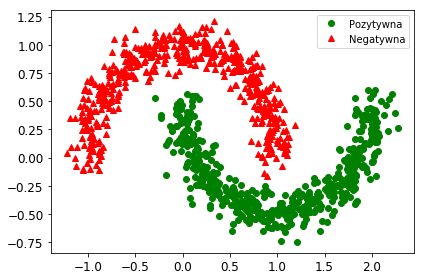

In [28]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Pozytywna")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negatywna")
plt.legend()

save_fig("wykres_danych_sierpowatych")
plt.show()

Nie możemy zapomnieć o wstawieniu dodatkowej cechy obciążenia ($x_0 = 1$) do każdej próbki. W tym celu wystarczy dodać kolumnę wypełnioną jedynkami po lewej stronie macierzy wejściowej $\mathbf{X}$:

In [6]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

Sprawdźmy:

In [7]:
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

Wygląda to nieźle. Przekształćmy teraz zmienną `y_train` w wektor kolumnowy (tj. w dwuwymiarową tablicę zawierającą tylko jedną kolumnę):

In [8]:
y_moons_column_vector = y_moons.reshape(-1, 1)

Rozdzielmy dane na podzbiory uczący i testowy:

In [9]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

W porządku, stwórzmy teraz niewielką funkcję generującą grupy uczące. W tej implementacji będziemy po prostu losowo dobierać próbki ze zbioru uczącego. Oznacza to, że pojedyncza grupa może zawierać wiele kopii tej samej próbki, a do tego w pojedynczej epoce mogą nie być przetworzone wszystkie próbki uczące (w rzeczywistości w każdej epoce będą wykorzystywane zaledwie w przybliżeniu dwie trzecie próbek). W praktyce jednak nie stanowi to problemu, a pozwala nam uprościć kod:

In [10]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

Przyjrzyjmy się mini-grupie:

In [11]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        , -0.77267555,  0.75156907],
       [ 1.        ,  1.86573336,  0.04824521],
       [ 1.        ,  0.53143405, -0.26140775],
       [ 1.        ,  0.00750921,  0.97881212],
       [ 1.        ,  0.78456462,  0.81751878]])

In [12]:
y_batch

array([[0],
       [1],
       [1],
       [0],
       [0]], dtype=int64)

Świetnie! Dane mogą zostać teraz dostarczone do modelu, więc możemy zabrać się za jego konstruowanie. Zacznijmy najpierw od prostej implementacji, a następnie będziemy dodawać kolejne funkcje.

Zresetujmy najpierw domyślny graf.

In [13]:
import tensorflow as tf

reset_graph()

Zestaw danych _moons_ ma dwie cechy wejściowe, gdyż każda próbka stanowi punkt na płaszczyźnie (dwuwymiarowej):

In [14]:
n_inputs = 2

Stwórzmy teraz model regresji logistycznej. Jak już wiemy z rozdziału 4., model ten oblicza najpierw sumę ważoną wejść (podobnie jak model regresji liniowej), a następnie przetwarza wynik przez funkcję sigmoidalną, dającą w rezultacie szacowane prawdopodobieństwo przynależności do klasy pozytywnej:

$\hat{p} = h_\mathbf{\theta}(\mathbf{x}) = \sigma(\mathbf{\theta}^T \cdot \mathbf{x})$


Pamiętaj, że $\mathbf{\theta}$ jest wektorem parametrów zawierającym człon obciążenia $\theta_0$ i wagi $\theta_1, \theta_2, \dots, \theta_n$. Wektor wejściowy $\mathbf{x}$ przechowuje stały człon $x_0 = 1$, jak również wszystkie cechy wejściowe $x_1, x_2, \dots, x_n$.

Chcemy móc jednocześnie uzyskiwać prognozy dla wielu próbek jednocześnie, dlatego będziemy korzystać z macierzy wejściowej $\mathbf{X}$ zamiast z pojedynczego wektora wejściowego. Rząd $i$-ty będzie przechowywał transpozycję $i$-tego wektora wejściowego $(\mathbf{x}^{(i)})^T$. W ten sposób możliwe staje się oszacowanie prawdopodobobieństwa przynależności każdej próbki do klasy pozytywnej za pomoca następującego równania:

$ \hat{\mathbf{p}} = \sigma(\mathbf{X} \cdot \mathbf{\theta})$

Ta wiedza wystarczy nam do stworzenia modelu:

In [15]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="teta")
logits = tf.matmul(X, theta, name="logity")
y_proba = 1 / (1 + tf.exp(-logits))

Instructions for updating:
Colocations handled automatically by placer.


W rzeczywistości moduł TensorFlow ma całkiem przyjemną funkcję `tf.sigmoid()`, dzięki której możemy uprościć ostatni wiersz powyższego kodu:

In [16]:
y_proba = tf.sigmoid(logits)

W rozdziale 4. dowiedzieliśmy się, że logarytmiczna funkcja straty stanowi odpowiednią funkcję kosztu w regresji logistycznej:

$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$

Możemy ją zaimplementować samodzielnie:

In [17]:
epsilon = 1e-7  # w celu uniknięcia przepełnienia w trakcie obliczania logarytmu
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))

Możemy jednak równie dobrze wykorzystać funkcję `tf.losses.log_loss()`:

In [18]:
loss = tf.losses.log_loss(y, y_proba)  # domyślnie wykorzystuje epsilon = 1e-7

Instructions for updating:
Use tf.cast instead.


Pozostała część kodu nie wyróżnia się niczym specjalnym: stwórzmy optymalizator i każmy mu minimalizować funkcję kosztu:

In [19]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

Potrzebujemy teraz tylko (w tej minimalnej implementacji) inicjatora zmiennych:

In [20]:
init = tf.global_variables_initializer()

Jesteśmy już gotowi wyuczyć model i użyć go do obliczania prognoz!

Naprawdę nie ma nic wyjątkowego w tym kodzie, jest praktycznie taki sam, jak użyty przez nas wcześniej w modelu regresji liniowej:

In [21]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoka:", epoch, "\tFunkcja straty:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoka: 0 	Funkcja straty: 0.79260236
Epoka: 100 	Funkcja straty: 0.34346348
Epoka: 200 	Funkcja straty: 0.3075404
Epoka: 300 	Funkcja straty: 0.29288894
Epoka: 400 	Funkcja straty: 0.28533572
Epoka: 500 	Funkcja straty: 0.28047803
Epoka: 600 	Funkcja straty: 0.27808294
Epoka: 700 	Funkcja straty: 0.27615443
Epoka: 800 	Funkcja straty: 0.27551997
Epoka: 900 	Funkcja straty: 0.27491233


Uwaga: podczas generowania mini-grup nie korzystamy z numeracji epok, dlatego wystarczyłaby nam pojedyczna pętla `for` zamiast dwóch zagnieżdżonych zapętleń, wygodnie jednak myśleć o czasie uczenia w kategoriach liczby epok (tj. przybliżonej liczbie przebiegów algorytmu po zestawie danych uczących).

Dla każdej próbki w zbiorze testowym wektor `y_proba_val` zawiera oszacowane prawdopodobieństwo jej przynależności do klasy pozytywnej według modelu. Na przykład poniżej widzimy pięć pierwszych oszacowanych prawdopodobieństw:

In [22]:
y_proba_val[:5]

array([[0.54895616],
       [0.7072436 ],
       [0.51900256],
       [0.99111354],
       [0.50859046]], dtype=float32)

W celu klasyfikowania każdej próbki, możemy skorzystać z metody maksymalnej wiarygodności: każda próbka, dla której została wyliczona wartość równa 0,5 lub większa zostaje sklasyfikowana jako należąca do klasy pozytywnej:

In [23]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]])

W zależności od zastosowania możemy wybrać próg inny, niż 0,5: jeśli wymagasz wysokiej precyzji, zwiększ ją (ale zmniejszysz w ten sposób pełność), a w przypadku chęci uzyskania dużej pełności obniż próg (ale zmniejszysz tym samym precyzję). Więcej szczegółów znajdziesz w rozdziale 3.

Obliczmy precyzję i pełność modelu:

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.8627450980392157

In [25]:
recall_score(y_test, y_pred)

0.8888888888888888

Stwórzmy wykres tych prognoz, aby przekonać się, jak one wyglądają:

Zapisywanie rysunku wykres_danych_sierpowatych_regresja1


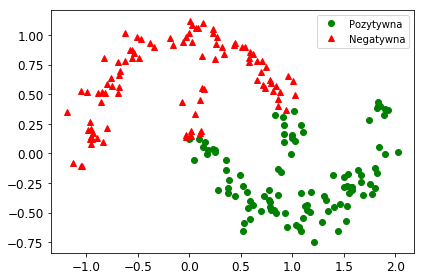

In [29]:
y_pred_idx = y_pred.reshape(-1) # jednowymiarowa tablica, a nie wektor kolumnowy
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Pozytywna")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negatywna")
plt.legend()

save_fig("wykres_danych_sierpowatych_regresja1")
plt.show()

Kiepsko to wygląda, prawda? Nie zapominajmy jednak, że model regresji logistycznej zawiera liniową granicę decyzyjną, zatem w rzeczywistości uzyskał on niemal idealne rezultaty w zakresie swoich możliwości (chyba że dodamy więcej cech, o czym przekonamy się już za moment).

Zacznijmy od początku, tym razem jednak wstawimy kilka dodatkowych elementów wymienionych w ćwiczeniu:
* wewnątrz funkcji `logistic_regression()` zdefiniuj graf, który będzie można z łatwością wielokrotnie wykorzystywać,
* w trakcie uczenia zapisuj punkty kontrolne w regularnych odstępach czasu za pomocą obiektu `Saver`, a także zachowaj ostateczny model po zakończeniu treningu,
* wczytaj ostatni punkt kontrolny, jeżeli proces uczenia został przerwany,
* zdefiniuj graf za pomocą zakresów nazw w taki sposób, żeby wyglądał czytelnie w aplikacji TensorBoard,
* dodaj podsumowania, aby zwizualizować krzywe uczenia w programie TensorBoard,
* spróbuj dostroić niektóre hiperparametry, np. współczynnik uczenia czy rozmiar mini-grup i przeanalizuj przebieg uzyskanej krzywej uczenia.

Zanim zaczniemy, dodamy jeszcze cztery cechy do danych wejściowych: ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ i ${x_2}^3$. Nie było to częścią ćwiczenia, ale pokażę w ten sposób, że dodawanie cech może poprawić dany model. Dokonamy tego ręcznie, jednak równie dobrze moglibyśmy je wstawić przy użyciu klasy `sklearn.preprocessing.PolynomialFeatures`.

In [30]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

Tak wygląda "usprawniony" zestaw danych uczących:

In [31]:
X_train_enhanced[:5]

array([[ 1.00000000e+00, -5.14696757e-02,  4.44198631e-01,
         2.64912752e-03,  1.97312424e-01, -1.36349734e-04,
         8.76459084e-02],
       [ 1.00000000e+00,  1.03201691e+00, -4.19741157e-01,
         1.06505890e+00,  1.76182639e-01,  1.09915879e+00,
        -7.39511049e-02],
       [ 1.00000000e+00,  8.67891864e-01, -2.54827114e-01,
         7.53236288e-01,  6.49368582e-02,  6.53727646e-01,
        -1.65476722e-02],
       [ 1.00000000e+00,  2.88850997e-01, -4.48668621e-01,
         8.34348982e-02,  2.01303531e-01,  2.41002535e-02,
        -9.03185778e-02],
       [ 1.00000000e+00, -8.33439108e-01,  5.35056649e-01,
         6.94620746e-01,  2.86285618e-01, -5.78924095e-01,
         1.53179024e-01]])

W porządku, następnie zresetujmy domyślny graf:

In [32]:
reset_graph()

Zdefiniujmy teraz funkcję `logistic_regression()` generującą nasz graf. Pominiemy definicje wartości wejściowych `X` i elementów docelowych `y`. Moglibyśmy je tu dołączyć, ale dzięki ich pominięciu funkcja ta będzie przydatna w większej liczbie zastosowań (np. może byśmy chcieli dołączyć jakieś operacje przetwarzania wstępnego danych wejściowych przed dostarczeniem ich do modelu regresji logistycznej).

In [33]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("regresja_logistyczna"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="teta")
            logits = tf.matmul(X, theta, name="logity")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("uczenie"):
            loss = tf.losses.log_loss(y, y_proba, scope="strata")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_strata', loss)
        with tf.name_scope("inicjacja"):
            init = tf.global_variables_initializer()
        with tf.name_scope("zapis"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

Stwórzmy niewielką funkcję określającą nazwę katalogu dzienników, w którym będą zapisywane podsumowania aplikacji TensorBoard: 

In [34]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/tf_dzienniki"
    if prefix:
        prefix += "-"
    name = prefix + "przebieg-" + now
    return "{}/{}/".format(root_logdir, name)

Stwórzmy teraz graf za pomocą funkcji `logistic_regression()`. Wygenerujemy również węzeł `FileWriter` zapisujący podsumowania w katalogu dzienników aplikacji TensorBoard:

In [36]:
n_inputs = 2 + 4 # dodatkowe cechy wielomianowe modelu
logdir = log_dir("logreg")    

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

W końcu możemy wyuczyć model! Zaczniemy od sprawdzenia, czy poprzednia sesja została przerwana - jeśli tak, to wczytamy punkt kontrolny i będziemy kontynuować trening od ostatnio zachowanego numeru epoki. W tym przykładzie zachowujemy jedynie numer epoki w osobnym pliku, ale w rozdziale 11. nauczymy się przechowywać etap uczenia bezpośrednio jako część modelu przy zastosowaniu niemodyfikowalnej zmiennej zwanej `global_step`, którą będziemy przekazywać metodzie `minimize()` optymalizatora.

Możemy spróbować przerwać uczenie, aby upewnić się, że model po ponownym uruchomieniu rzeczywiście rozpocznie pracę od poprzedniego punktu kontrolnego.

In [37]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/logreg/moj_logreg_modelu.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/logreg/tmp/moj_logreg_modelu"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # jeśli istnieje plik punktu kontrolnego, to odtwarza go i wczytuje numer epoki
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Uczenie zostało przerwane. Wznawiam od epoki", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoka:", epoch, "\tFunkcja straty:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoka: 0 	Funkcja straty: 0.62998503
Epoka: 500 	Funkcja straty: 0.16122366
Epoka: 1000 	Funkcja straty: 0.1190321
Epoka: 1500 	Funkcja straty: 0.097329214
Epoka: 2000 	Funkcja straty: 0.08369793
Epoka: 2500 	Funkcja straty: 0.07437582
Epoka: 3000 	Funkcja straty: 0.06750215
Epoka: 3500 	Funkcja straty: 0.062206898
Epoka: 4000 	Funkcja straty: 0.058026787
Epoka: 4500 	Funkcja straty: 0.05456297
Epoka: 5000 	Funkcja straty: 0.051708277
Epoka: 5500 	Funkcja straty: 0.04923773
Epoka: 6000 	Funkcja straty: 0.047167283
Epoka: 6500 	Funkcja straty: 0.045376644
Epoka: 7000 	Funkcja straty: 0.04381875
Epoka: 7500 	Funkcja straty: 0.042374235
Epoka: 8000 	Funkcja straty: 0.041089173
Epoka: 8500 	Funkcja straty: 0.039970923
Epoka: 9000 	Funkcja straty: 0.038920265
Epoka: 9500 	Funkcja straty: 0.038010757
Epoka: 10000 	Funkcja straty: 0.037155706


Również w tym przypadku możemy obliczać prognozy poprzez klasyfikowanie do klasy pozytywnej wszystkich próbek, dla których oszacowanie prawdopodobieństwa przynależności do niej jest większe lub równe 0,5:

In [38]:
y_pred = (y_proba_val >= 0.5)

In [39]:
precision_score(y_test, y_pred)

0.9797979797979798

In [40]:
recall_score(y_test, y_pred)

0.9797979797979798

Zapisywanie rysunku wykres_danych_sierpowatych_regresja2


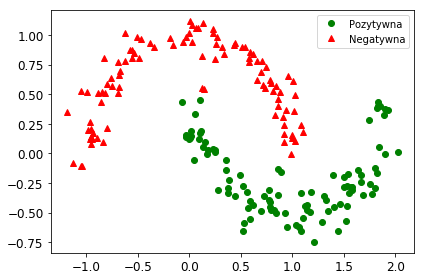

In [41]:
y_pred_idx = y_pred.reshape(-1) # jednowymiarowa tablica, a nie wektor kolumnowy
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Pozytywna")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negatywna")
plt.legend()

save_fig("wykres_danych_sierpowatych_regresja2")
plt.show()

Teraz jest znacznie, znacznie lepiej! Najwidoczniej nowe cechy okazały się bardzo pomocne.

Spróbuj uruchomić serwer Tensorboard, wyszukaj najnowszy przebieg i sprawdź jego krzywą uczenia (tzn. w jaki sposób funkcja straty sprawdzona wobec zestawu testowego rozwija się w funkcji numeru epoki):

```
$ tensorboard --logdir=tf_logs
```

Teraz możesz pobawić się hiperparametrami (np. takimi jak `batch_size` czy `learning_rate`) i przeprowadzać wielokrotnie proces uczenia w celu porównywania krzywych uczenia. Możesz nawet zautomatyzować ten proces implementując przeszukiwania siatki lub przeszukiwania losowe. Poniżej prezentuję prostą implementację przeszukiwania losowego wobec rozmiaru mini-grupy i współczynnika uczenia. W celu zachowania przejrzystości mechanizm tworzenia punktów kontrolnych został usunięty.

In [42]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Przebieg", search_iteration)
    print("  Katalog dzienników:", logdir)
    print("  Rozmiar mini-grupy:", batch_size)
    print("  Współczynnik uczenia:", learning_rate)
    print("  Trening: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "/Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/logreg/moj_logreg_modelu_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  Precyzja:", precision_score(y_test, y_pred))
        print("  Pełność:", recall_score(y_test, y_pred))

Przebieg 0
  Katalog dzienników: /Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/tf_dzienniki/logreg-przebieg-20190318130844/
  Rozmiar mini-grupy: 54
  Współczynnik uczenia: 0.004430375245218265
  Trening: .....................
  Precyzja: 0.9797979797979798
  Pełność: 0.9797979797979798
Przebieg 1
  Katalog dzienników: /Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/tf_dzienniki/logreg-przebieg-20190318130953/
  Rozmiar mini-grupy: 22
  Współczynnik uczenia: 0.0017826497151386947
  Trening: .....................
  Precyzja: 0.9797979797979798
  Pełność: 0.9797979797979798
Przebieg 2
  Katalog dzienników: /Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/tf_dzienniki/logreg-przebieg-20190318131226/
  Rozmiar mini-grupy: 74
  Współczynnik uczenia: 0.00203228544324115
  Trening: .....................
  Precyzja: 0.9696969696969697
  Pełność: 0.9696969696969697
Przebieg 3
  Katalog dzienników: /Users/mdabrowski/ML/Geron_UczenieMaszynowe/tensorflow/tf_dzienniki/logreg-p

Funkcja `reciprocal()` z modułu `stats` biblioteki SciPy zwraca rozkład losowy, z którego powszechnie korzystamy, gdy nie wiemy, jaka skala jest optymalna dla danego hiperparametru. Więcej szczegółów znajdziesz w rozwiązaniach ćwiczeń z rozdziału 2. 